### Problem Statement
#### To predict the fare of the taxi ride using Random Forest given pickup and drop-off locations, the pickup timestamp, and the passenger count ####

### Data Understanding
#### unique_id= A unique identifier or key for each record in the dataset ####
####  date_time_of_pickup= The time when the ride started ####
#### longitude_of_pickup= Longitude of the taxi ride pickup point ####
#### latitude_of_pickup= Latitude of the taxi ride pickup point ####
#### longitude__of_dropoff= Longitude of the taxi ride dropoff point ####
#### latitude_of_dropoff= Latitude of the taxi ride dropoff ####
#### point no_of_passenger= count of the passengers during the ride ####
#### Amount= (target variable) dollar amount of the cost of the taxi ride  ####



In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#import scipy.stats as st

### (1) Data Reading

In [322]:
tx = pd.read_csv("TaxiFare.csv")

In [323]:
tx.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


### (2) Data Preparation

In [324]:
tx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unique_id             50000 non-null  object 
 1   amount                50000 non-null  float64
 2   date_time_of_pickup   50000 non-null  object 
 3   longitude_of_pickup   50000 non-null  float64
 4   latitude_of_pickup    50000 non-null  float64
 5   longitude_of_dropoff  50000 non-null  float64
 6   latitude_of_dropoff   50000 non-null  float64
 7   no_of_passenger       50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [325]:
tx["amount"].describe() 

count    50000.000
mean        11.364
std          9.686
min         -5.000
25%          6.000
50%          8.500
75%         12.500
max        200.000
Name: amount, dtype: float64

In [326]:
index_names = tx[tx["amount"]<2.5].index # we dropped it because the charge of taxi in new york can never be less than 2.5

In [327]:
index_names

Int64Index([2039, 2486, 2780, 10002, 13032, 27891, 28839, 36722, 42337, 47302], dtype='int64')

In [328]:
tx.drop(index_names,inplace=True)

#### Taxi fare amount can never be negative, also the charge of taxi can never be less than 2.5 in New York so dropping them. 

#### Checking the Presence of Outliers in Dataset

In [329]:
tx.describe(percentiles = [0.01,.02,.03,.04,.05,.1,.25,.4,.5,.75,.9,.95,.96,.98,.99]).T

,count,mean,std,min,1%,2%,3%,4%,5%,10%,25%,40%,50%,75%,90%,95%,96%,98%,99%,max
amount,49990.0,11.367,9.685,2.500,3.300,3.500,3.700,4.000,4.100,4.500,6.000,7.300,8.500,12.500,20.500,30.500,33.566,46.500,52.000,200.000
longitude_of_pickup,49990.0,-72.509,10.395,-75.424,-74.014,-74.010,-74.009,-74.008,-74.007,-74.003,-73.992,-73.986,-73.982,-73.967,-73.951,-73.871,-73.863,-73.137,0.000,40.783
latitude_of_pickup,49990.0,39.934,6.225,-74.007,0.000,40.579,40.645,40.681,40.702,40.718,40.735,40.747,40.753,40.767,40.780,40.788,40.791,40.800,40.807,401.083
longitude_of_dropoff,49990.0,-72.506,10.404,-84.654,-74.015,-74.012,-74.010,-74.008,-74.007,-74.003,-73.991,-73.984,-73.980,-73.964,-73.945,-73.873,-73.864,-73.434,0.000,40.851
latitude_of_dropoff,49990.0,39.927,6.013,-74.006,0.000,40.570,40.647,40.673,40.686,40.713,40.734,40.748,40.753,40.768,40.783,40.794,40.799,40.810,40.833,43.415
no_of_passenger,49990.0,1.668,1.289,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000,4.000,5.000,5.000,5.000,6.000,6.000


In [330]:
tx["X1"] = tx["latitude_of_pickup"]
tx["X2"] = tx["latitude_of_dropoff"]
tx["Y1"] = tx["longitude_of_pickup"]
tx["Y2"] = tx["longitude_of_dropoff"]

In [331]:
tx["Distance_Travel"] = np.sqrt((np.square(tx["X1"]-tx["X2"]))+(np.square(tx["Y1"]-tx["Y2"])))

#### We have used the Euclidean Distance formula to calculate the distance.

In [332]:
tx1=tx.drop(columns=["longitude_of_pickup","latitude_of_pickup","longitude_of_dropoff","latitude_of_dropoff"])

In [333]:
tx1[["date","Time","Zone"]]=tx1["date_time_of_pickup"].str.split(pat=" ",n=-1 , expand=True)
#splitting the date_time_of_pickup in separate columns.

In [334]:
tx2 = tx1.copy()

In [335]:
tx2["amount"] = np.where(tx2["amount"]>=52, 52, tx2["amount"])
tx2["no_of_passenger"] = np.where(tx2["no_of_passenger"]>=5, 4, tx2["no_of_passenger"])
tx2["Distance_Travel"] = np.where(tx2["Distance_Travel"]>=0.228218, 0.228218, tx2["Distance_Travel"])
#Outlier Treatment

In [336]:
tx2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49990 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unique_id            49990 non-null  object 
 1   amount               49990 non-null  float64
 2   date_time_of_pickup  49990 non-null  object 
 3   no_of_passenger      49990 non-null  int64  
 4   X1                   49990 non-null  float64
 5   X2                   49990 non-null  float64
 6   Y1                   49990 non-null  float64
 7   Y2                   49990 non-null  float64
 8   Distance_Travel      49990 non-null  float64
 9   date                 49990 non-null  object 
 10  Time                 49990 non-null  object 
 11  Zone                 49990 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 5.0+ MB


In [337]:
tx2["date"] = pd.to_datetime(tx2["date"])
tx2["date_time_of_pickup"] = pd.to_datetime(tx2["date_time_of_pickup"])
#Changig the type from object to datetime.

In [338]:
tx2["hours"] = tx2["date_time_of_pickup"].dt.hour
tx2["min"] = tx2["date_time_of_pickup"].dt.minute
tx2["second"] = tx2["date_time_of_pickup"].dt.second
tx2["year"] = tx2["date_time_of_pickup"].dt.year
tx2["day_of_the_month"] = tx2["date_time_of_pickup"].dt.day
#Extracting some features from date_time_of_pickup

In [339]:
def time_of_day(x):
    if x in range(6,12):
        return "Morning"
    elif x in range(12,17):
        return "Afternoon"
    elif x in range(17,21):
        return "Evening"
    else:
        return "Night"

In [340]:
tx2["time_of_day"] = tx2["hours"].apply(time_of_day)

In [341]:
tx2["day"] = tx2["date_time_of_pickup"].dt.day_name()
tx2["day_no"] = tx2["date_time_of_pickup"].dt.weekday

In [342]:
# Remove latitude and longtiude outliers
tx2 = tx2.loc[tx2['X1'].between(40, 42)]
tx2 = tx2.loc[tx2['Y1'].between(-75, -72)]
tx2 = tx2.loc[tx2['X2'].between(40, 42)]
tx2 = tx2.loc[tx2['Y2'].between(-75, -72)]
print(f'New number of observations: {tx2.shape[0]}')


New number of observations: 48944


In [343]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)


#### Using Manhattan Distance

In [344]:
tx2['manhattan_d'] = minkowski_distance(tx2['Y1'], 
                                       tx2['Y2'],
                                       tx2['X1'],
                                       tx2['X2'], 1)


#### Graphical Analysis

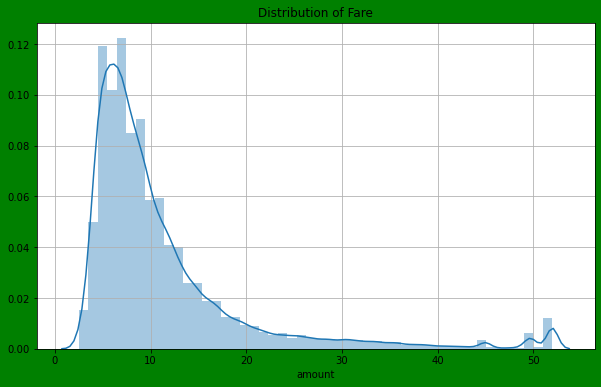

In [345]:
plt.figure(figsize = (10, 6),facecolor="green")
sns.distplot(tx2['amount']);
plt.title('Distribution of Fare')
plt.grid()
plt.savefig('Distribution of Fare.jpg')

##### We checked the distribution of the amount/fare and as it can be seen the distribution is highly skewed. In addition, the density of fare in the range of 0 to 20 is significantly higher. This could indicate that individuals prefer not to use taxi services for lengthy distances because long distances imply a high fare.#####



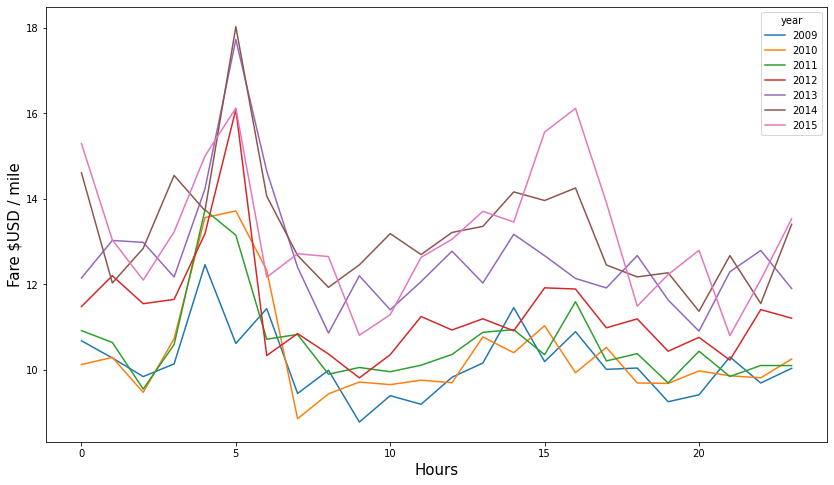

In [346]:
tx2.pivot_table(index='hours', columns='year', values="amount",aggfunc="mean").plot(figsize=(14,8))
plt.xlabel("Hours",fontsize=(15))
plt.ylabel('Fare $USD / mile',fontsize=(15))
plt.savefig('Fare $USD_mile.jpg')


#### For different years, this graph displays the link between fare/mile and hour. Each crooked line represents a distinct year's fare movement. Every line has some ascend between 5 and 7 a.m., which is often the commencement of business hours, and therefore a spike in fare can be expected.####

In [347]:
tx2.head()

,unique_id,amount,date_time_of_pickup,no_of_passenger,X1,X2,Y1,Y2,Distance_Travel,date,...,Zone,hours,min,second,year,day_of_the_month,time_of_day,day,day_no,manhattan_d
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,1,40.721,40.712,-73.844,-73.842,0.009,2009-06-15,...,UTC,17,26,21,2009,15,Evening,Monday,0,0.012
1,52:16.0,16.9,2010-01-05 16:52:16+00:00,1,40.711,40.782,-74.016,-73.979,0.080,2010-01-05,...,UTC,16,52,16,2010,5,Afternoon,Tuesday,1,0.107
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,2,40.761,40.751,-73.983,-73.991,0.014,2011-08-18,...,UTC,0,35,0,2011,18,Night,Thursday,3,0.019
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,1,40.733,40.758,-73.987,-73.992,0.025,2012-04-21,...,UTC,4,30,42,2012,21,Night,Saturday,5,0.029
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,1,40.768,40.784,-73.968,-73.957,0.019,2010-03-09,...,UTC,7,51,0,2010,9,Morning,Tuesday,1,0.027


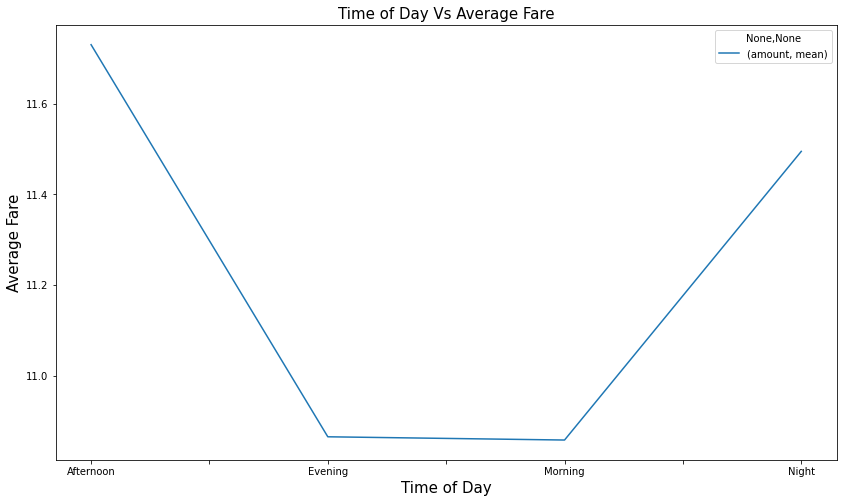

In [348]:
tx2.groupby(tx2["time_of_day"]).agg({"amount":["mean"]}).plot(figsize=(14,8))
plt.title("Time of Day Vs Average Fare",fontsize=(15))
plt.xlabel("Time of Day",fontsize=(15))
plt.ylabel('Average Fare',fontsize=(15))
plt.savefig("Time_of_Day_vs_Average_Fare.jpg")

#### We have now divided the entire 24-hour period into four pieces.

Morning: 6 a.m. to 12 p.m.

Afternoon: 12 p.m. to 17 p.m.

Afternoon: 17 p.m. to 21 p.m.

Evening: 21 p.m. to 6 a.m.

In comparison to the other times, the fare is significantly higher in the afternoon and at night. This increase could be related to the unusual hours, as most cab firms impose a night premium so that drivers don't cancel rides and lose out on the odd hour incentives. 

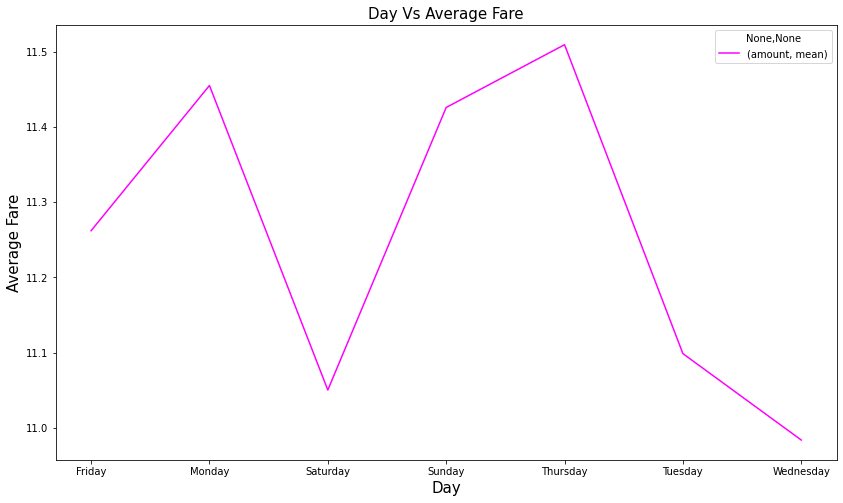

In [349]:
tx2.groupby(tx2["day"]).agg({"amount":["mean"]}).plot(figsize=(14,8),color="magenta")
plt.title("Day Vs Average Fare",fontsize=(15))
plt.xlabel("Day",fontsize=(15))
plt.ylabel('Average Fare',fontsize=(15))
plt.savefig("Day_vs_Average_Fare.jpg")

#####  We see an unusual pattern here, as the average fare on weekends should be lower than on other days. A portion of this can be seen in the Saturday drop in average fare. However, Sunday is the day when most people plan intercity journeys to shops and restaurants, so the small increase on Sunday could be related to that.



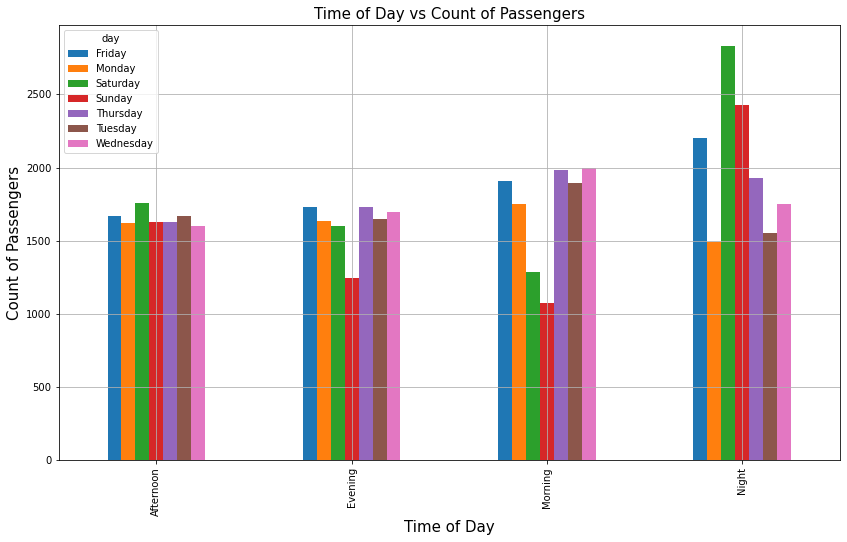

In [350]:
tx2.pivot_table(index='time_of_day', columns='day', values="no_of_passenger",aggfunc="count").plot(figsize=(14,8),kind='bar')
plt.title("Time of Day vs Count of Passengers",fontsize=(15))
plt.xlabel("Time of Day",fontsize=(15))
plt.ylabel('Count of Passengers',fontsize=(15));
plt.grid()
plt.savefig("Time_of_Day_vs_Count_of_Passengers.jpg")

#### The suitable trend may be seen when looking at the time of day vs. the number of passengers on different days. The majority of passengers travelling at night do so on weekends, particularly on Saturday and Sunday, while for other times of day, particularly in the morning, less people use taxi services on Saturday and Sunday.

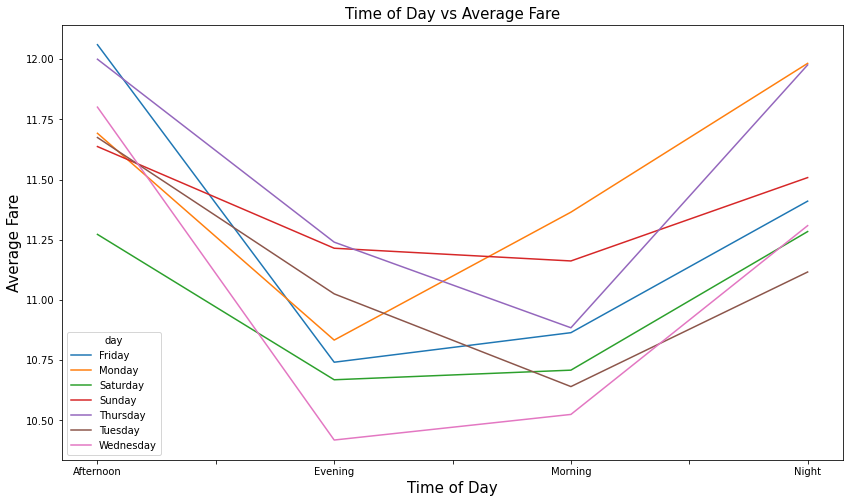

In [351]:
tx2.pivot_table(index='time_of_day', columns='day', values="amount",aggfunc="mean").plot(figsize=(14,8))
plt.title("Time of Day vs Average Fare",fontsize=(15))
plt.xlabel("Time of Day",fontsize=(15))
plt.ylabel('Average Fare',fontsize=(15))
plt.savefig("Time_of_Day_vs_Average_Fare.jpg")

#### It's merely a different version of the graph above. With respect to different days, time of day vs. average fare. Wednesday has the lowest average fare for evening and morning travel, while Friday and Monday have the highest average fare for afternoon and night travel.

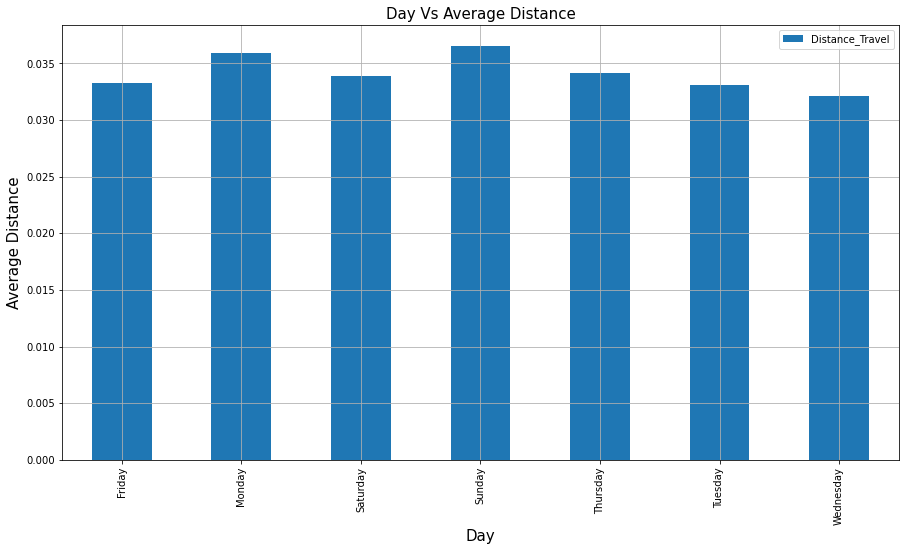

In [352]:
tx2.pivot_table(index="day",values= "Distance_Travel",aggfunc="mean").plot(figsize=(15,8),kind='bar')
plt.title("Day Vs Average Distance",fontsize=(15))
plt.xlabel("Day",fontsize=(15))
plt.ylabel('Average Distance',fontsize=(15));
plt.grid()
plt.savefig("Day Vs Average Distance.jpg")

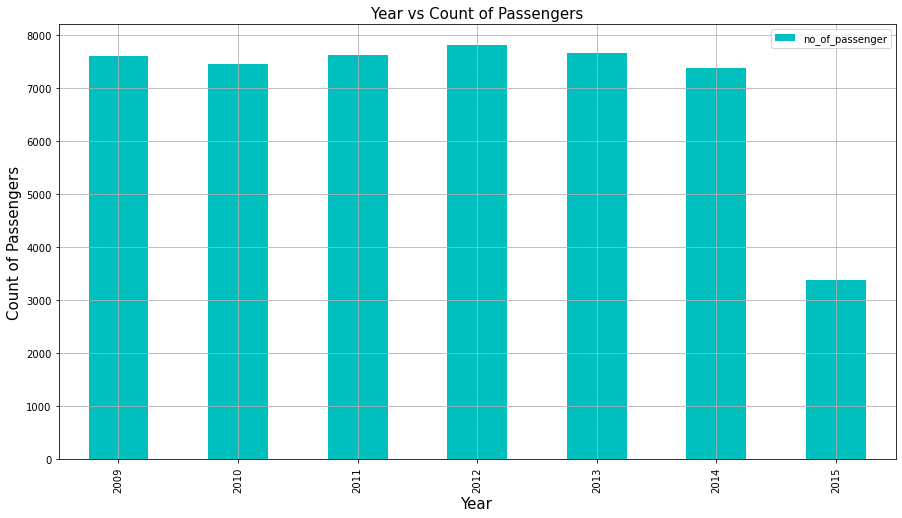

In [353]:
tx2.pivot_table(index="year",values= "no_of_passenger",aggfunc="count").plot(figsize=(15,8), kind='bar',color='c')
plt.title("Year vs Count of Passengers",fontsize=(15))
plt.xlabel("Year",fontsize=(15))
plt.ylabel('Count of Passengers',fontsize=(15));
plt.grid()
plt.savefig("Year vs Count of Passengers.jpg")

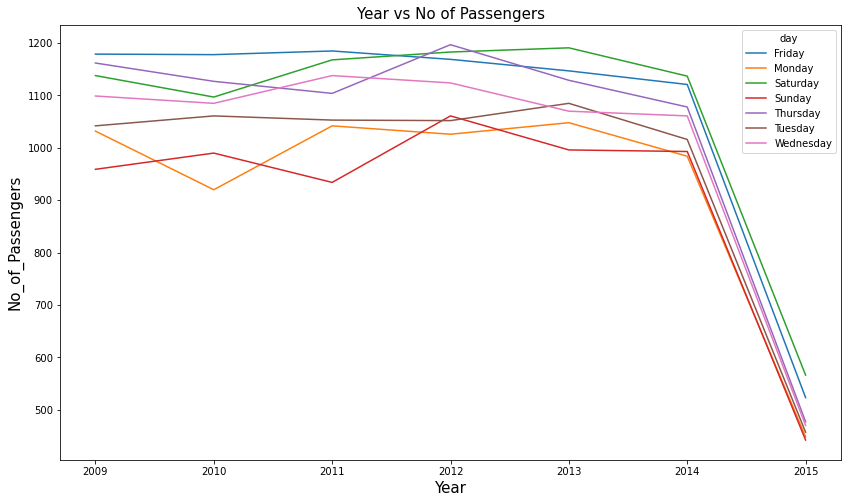

In [354]:
tx2.pivot_table(index="year",columns="day",values="no_of_passenger",aggfunc="count").plot(figsize=(14,8))
plt.title("Year vs No of Passengers",fontsize=(15))
plt.xlabel("Year",fontsize=(15))
plt.ylabel('No_of_Passengers',fontsize=(15))
plt.savefig("Year vs No of Passengers.jpg")


The number of passengers is falling at the end of 2014, as seen in the graph above, and the trend of each day for the given years is similar.

In [355]:
tx2.select_dtypes(include='O').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48944 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   unique_id    48944 non-null  object
 1   Time         48944 non-null  object
 2   Zone         48944 non-null  object
 3   time_of_day  48944 non-null  object
 4   day          48944 non-null  object
dtypes: object(5)
memory usage: 3.5+ MB


In [356]:
tx2.drop(columns=["unique_id","Time","Zone","date","min","second","date_time_of_pickup","X1","X2","Y1","Y2"],inplace =True)

In [357]:
# 1: Yes
# 0: No
# Is_Weekend - if day_no between (0,6) : 1
#              else i.e (1 to 5): 0
# Is_starting_of_month - day of month between (1-10)
# Is_middle_of_month - day of month between (15-20)
# Is_end_of_month - day of month between (20-31)


In [358]:
tx3 = pd.get_dummies(tx2,columns=["time_of_day","day"]) #Dummy Creation

In [359]:
tx3["Is_Weekend"] =np.where(tx3["day_no"].isin ([0,6]),1,0)
tx3["Is_starting_of_month"] = np.where(tx3["day_of_the_month"].isin ([1,2,3,4,5,6,7,8,9,10]),1,0)
tx3["Is_middle_of_month"] = np.where(tx3["day_of_the_month"].isin (range(11,21)),1,0)
tx3["Is_end_of_month"] = np.where(tx3["day_of_the_month"].isin (range(21,32)),1,0)
tx3["Is_leap_year"] = np.where((tx3["year"]%4 == 0),1,0)

In [360]:
tx3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48944 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount                 48944 non-null  float64
 1   no_of_passenger        48944 non-null  int64  
 2   Distance_Travel        48944 non-null  float64
 3   hours                  48944 non-null  int64  
 4   year                   48944 non-null  int64  
 5   day_of_the_month       48944 non-null  int64  
 6   day_no                 48944 non-null  int64  
 7   manhattan_d            48944 non-null  float64
 8   time_of_day_Afternoon  48944 non-null  uint8  
 9   time_of_day_Evening    48944 non-null  uint8  
 10  time_of_day_Morning    48944 non-null  uint8  
 11  time_of_day_Night      48944 non-null  uint8  
 12  day_Friday             48944 non-null  uint8  
 13  day_Monday             48944 non-null  uint8  
 14  day_Saturday           48944 non-null  uint8  
 15  da

### (3) Applying Model

In [361]:
y = tx3["amount"]
X = tx3.drop(columns=["amount"])

In [362]:
corr_data=X.corr()
pd.set_option("precision",3)
corr_data.style.background_gradient(cmap="coolwarm")

,no_of_passenger,Distance_Travel,hours,year,day_of_the_month,day_no,manhattan_d,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,Is_Weekend,Is_starting_of_month,Is_middle_of_month,Is_end_of_month,Is_leap_year
no_of_passenger,1.000,0.016,0.014,-0.006,0.007,0.048,0.013,-0.006,0.015,-0.050,0.038,0.004,-0.013,0.038,0.031,-0.024,-0.023,-0.014,0.013,-0.006,-0.003,0.009,-0.003
Distance_Travel,0.016,1.000,-0.034,0.026,-0.000,0.008,0.936,-0.005,-0.031,-0.033,0.064,-0.009,0.019,-0.002,0.025,0.001,-0.010,-0.021,0.034,-0.000,0.003,-0.003,0.002
hours,0.014,-0.034,1.000,0.005,-0.007,-0.091,-0.031,0.037,0.426,-0.405,-0.048,0.006,0.029,-0.028,-0.097,0.027,0.036,0.025,-0.052,0.006,-0.001,-0.004,-0.002
year,-0.006,0.026,0.005,1.000,-0.011,0.006,0.017,-0.010,-0.002,0.003,0.008,-0.005,0.003,0.010,0.006,-0.007,-0.001,-0.005,0.006,0.008,0.003,-0.011,0.061
day_of_the_month,0.007,-0.000,-0.007,-0.011,1.000,0.008,0.000,0.010,-0.010,-0.001,0.001,0.005,-0.001,0.009,0.002,-0.008,-0.003,-0.005,0.001,-0.808,-0.015,0.818,-0.004
day_no,0.048,0.008,-0.091,0.006,0.008,1.000,0.006,-0.002,-0.039,-0.090,0.124,0.211,-0.606,0.427,0.587,-0.007,-0.416,-0.216,-0.018,-0.008,0.004,0.003,0.005
manhattan_d,0.013,0.936,-0.031,0.017,0.000,0.006,1.000,-0.005,-0.027,-0.025,0.053,-0.009,0.017,-0.000,0.021,0.000,-0.010,-0.018,0.029,-0.002,0.004,-0.001,-0.000
time_of_day_Afternoon,-0.006,-0.005,0.037,-0.010,0.010,-0.002,-0.005,1.000,-0.305,-0.315,-0.356,-0.014,0.012,-0.002,0.018,-0.012,0.010,-0.009,0.022,-0.004,-0.008,0.012,-0.008
time_of_day_Evening,0.015,-0.031,0.426,-0.002,-0.010,-0.039,-0.027,-0.305,1.000,-0.310,-0.350,-0.000,0.019,-0.016,-0.033,0.007,0.013,0.010,-0.010,0.008,0.002,-0.010,-0.000
time_of_day_Morning,-0.050,-0.033,-0.405,0.003,-0.001,-0.090,-0.025,-0.315,-0.310,1.000,-0.362,0.011,0.024,-0.070,-0.067,0.029,0.034,0.038,-0.033,-0.001,0.006,-0.005,-0.001


#### Splitting the Data into Train and Test

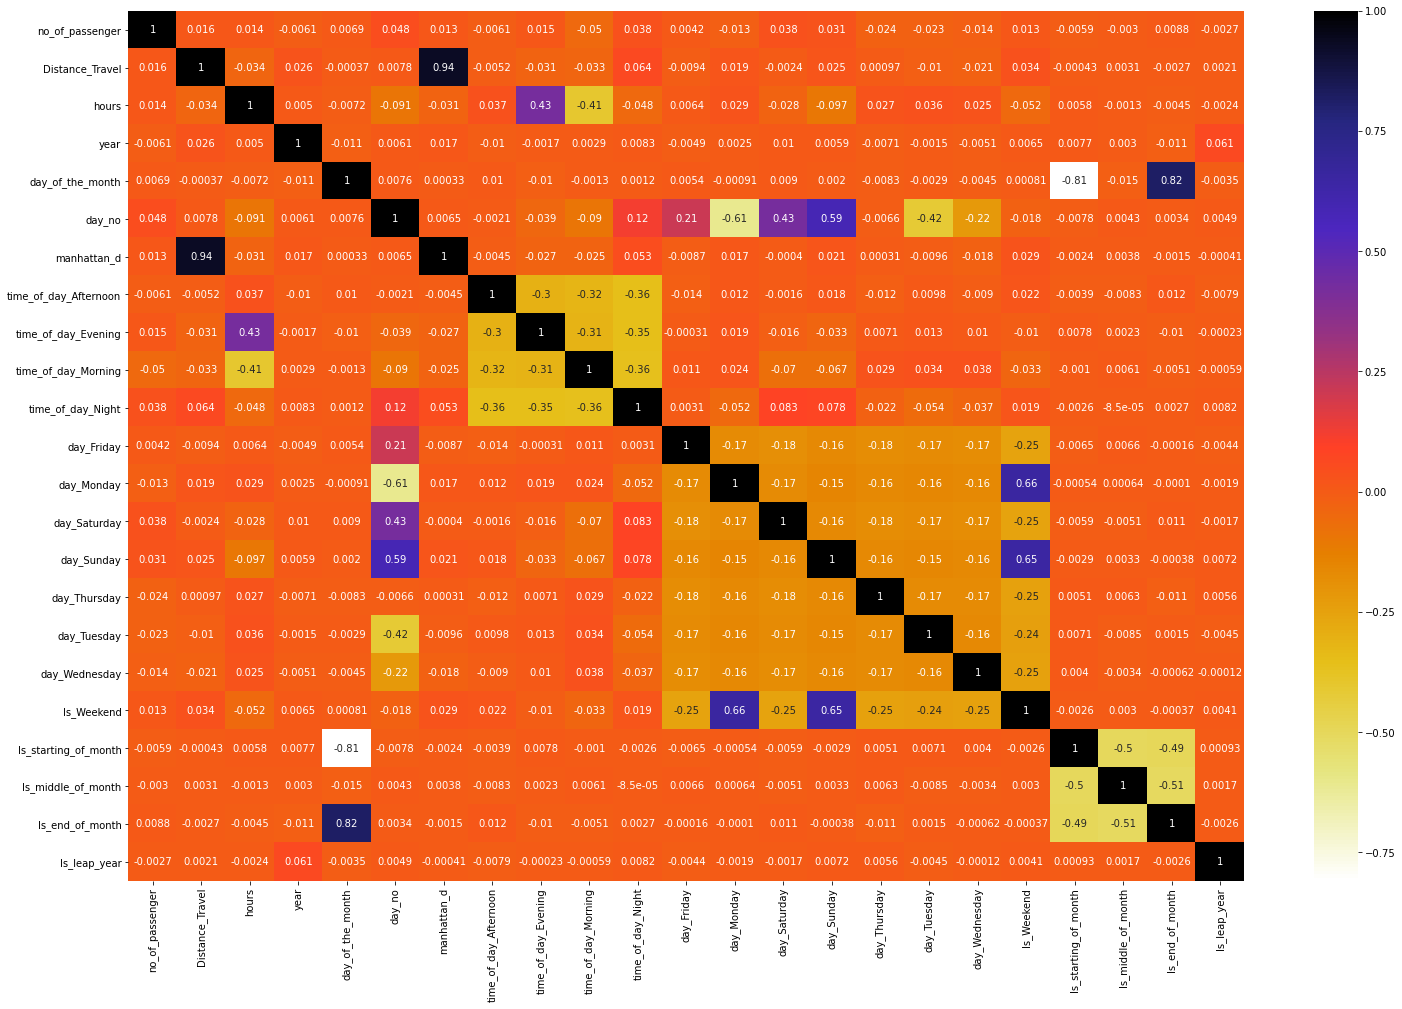

In [372]:
#Using Pearson Correlation.......
plt.figure(figsize=(25,16))
sns.heatmap(corr_data, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [363]:
X_train,X_test,y_train,y_test =train_test_split(X,y, test_size = 0.2 , random_state = 1)

In [364]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39155 entries, 15614 to 33714
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   no_of_passenger        39155 non-null  int64  
 1   Distance_Travel        39155 non-null  float64
 2   hours                  39155 non-null  int64  
 3   year                   39155 non-null  int64  
 4   day_of_the_month       39155 non-null  int64  
 5   day_no                 39155 non-null  int64  
 6   manhattan_d            39155 non-null  float64
 7   time_of_day_Afternoon  39155 non-null  uint8  
 8   time_of_day_Evening    39155 non-null  uint8  
 9   time_of_day_Morning    39155 non-null  uint8  
 10  time_of_day_Night      39155 non-null  uint8  
 11  day_Friday             39155 non-null  uint8  
 12  day_Monday             39155 non-null  uint8  
 13  day_Saturday           39155 non-null  uint8  
 14  day_Sunday             39155 non-null  uint8  
 15

In [365]:
xtrain_matrix = X_train.describe().T

In [366]:
xtest_matrix= X_test.describe().T

In [367]:
xtest_matrix.to_excel("X_test.xlsx")
xtrain_matrix.to_excel("X_train.xlsx")

#### Using RandomForest Regressor

In [368]:
rf2 = RandomForestRegressor()
rf2.fit(X_train,y_train)
print("Train R2", rf2.score(X_train,y_train))
print("Test R2",rf2.score(X_test,y_test))

Train R2 0.9751193760477161
Test R2 0.8181435106124311


In [369]:
param = {"n_estimators":[20,50],"criterion":['squared_error'] ,"max_depth": [3,5],"min_samples_split":[2,4],
                "min_samples_leaf":[2,4]}

rf3 = RandomForestRegressor()
Grid_search = GridSearchCV(estimator = rf3, param_grid=param,cv=5,verbose=1,n_jobs=-1)
Grid_search.fit(X_train,y_train)




Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [3, 5],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [20, 50]},
             verbose=1)

In [370]:
print("Train R2", Grid_search.score(X_train,y_train))
print("Test R2",Grid_search.score(X_test,y_test))


Train R2 0.8279777616796484
Test R2 0.8211391007208809


In [371]:
print("MAE of Train: ", np.mean(np.abs((y_train-Grid_search.predict(X_train))) ))
print("MAE of Test: ", np.mean(np.abs((y_test-Grid_search.predict(X_test))) ))
print("RMSE of Train: ", np.sqrt(np.mean((y_train-Grid_search.predict(X_train))**2) ))
print("RMSE of Test: ", np.sqrt(np.mean((y_test-Grid_search.predict(X_test))**2) ))


MAE of Train:  2.0765463310743533
MAE of Test:  2.1104685407850217
RMSE of Train:  3.718283357994142
RMSE of Test:  3.7747598411619414


R2 is a measure of how well a model predicts the target variables. The error is calculated using the RMSE and MAE methods. As can be seen, our model has good accuracy and a low bias/variance trade-off. We can conclude from this analysis that our model is performing well.
